In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Frog:
    def __init__(self, n=10, gamma=0.99, initial_alpha=0.1, initial_eps=0.9, num_simulations = 50,
                 hyperparameter_scheme=2, rewards_choice=2
                ):
        self.n = n
        self.gamma = gamma
        self.initial_alpha = initial_alpha
        self.initial_eps = initial_eps
        self.state_space = list(range(n+1))
        self.terminal_space = [0, n]
        self.action_space = ['A', 'B']
        
        self.hyperparameter_scheme = hyperparameter_scheme
        self.rewards_choice = rewards_choice
        
        #initialization - might impact the speed of training (especially in early stages), but should not impact the outcome
        #self.Q = np.zeros([len(self.state_space), len(self.action_space)])
        self.Q = np.random.rand( len(self.state_space), len(self.action_space))
        
        self.num_simulations = num_simulations
        self.simulated_rewards = []
    
    
    def eps_greedy_action(self, eps):
        rv = np.random.uniform(0,1)
        if rv < eps:
            #random action
            return np.random.choice(self.action_space)
        else:
            #follow the best action
            return self.action_space[np.argmax(self.Q[self.state, :])]

    
    def action_A(self, state):
        rv = np.random.uniform(0,1)
        if rv < float(state)/self.n:
            return state - 1
        else:
            return state + 1
        
    def action_B(self, state):
        state_space = list(self.state_space)
        state_space.pop(state)
        return np.random.choice(state_space)
    
    def choose_reward_function(self, state):
        if self.rewards_choice == 1:
            return self.get_reward(state)
        elif self.rewards_choice == 2:
            return self.get_reward2(state)
        else:
            print("ERROR! Unknown reward function")
    
    def get_reward(self, state):
        #reward assignment - you can experiment with different rewards
        return float(state)/self.n
        
    def get_reward2(self, state):
        #reward assignment - you can experiment with different rewards
        if state == 0:
            return 0
        elif state == self.n:
            return 1
        else:
            return 0
        
    def simulate(self, num_simulation):
        simulated_rewards = []
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            while state not in self.terminal_space:
                #follow the best policy
                action = self.action_space[np.argmax(self.Q[state, :])]            
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                state = state_new   
            simulated_rewards.append(reward)
        #return cumlated rewards over num_episode simulations for a given policy
        return np.mean(simulated_rewards)
    
    def simulate_for_large_n(self, num_simulation):
        #this function might be useful for testing/debugging your code for large n
        simulated_rewards = []
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            num_iter = 0
            while state not in self.terminal_space and (num_iter<0.5e7):
                #with a small probability pick action B not to be stuck in the infinite loop traversing the lilypads,
                #otherwise follow the best policy
                rv = np.random.uniform(0,1)
                if rv < 1e-2:
                    action = 'B'
                else:
                    action = self.action_space[np.argmax(self.Q[state, :])]              
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                state = state_new
                num_iter +=1
            if (num_iter<0.5e7):
                simulated_rewards.append(reward)
            else: 
                print("Dropped rewards due to large time needed to simulate")
        #return cumlated rewards over num_episode simulations for a given policy (this value is calibrated to n=25)
        return np.mean(simulated_rewards)
    
    def choose_hyperparameter_scheme(self, i, num_episode):
        if self.hyperparameter_scheme == 1:
            return self.my_hyperparameter_scheme_1(i, num_episode)
        elif self.hyperparameter_scheme == 2:
            return self.my_hyperparameter_scheme_2(i, num_episode)
        else:
            print("ERROR! Unknown hyperparameter scheme")
    
    def my_hyperparameter_scheme_1(self, i, num_episode):
        if i<500:
            eps =  self.initial_eps
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        else:
            eps = 0
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode/10
        return [eps, alpha]
    
    def my_hyperparameter_scheme_2(self, i, num_episode):
        eps =  self.initial_eps
        alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        return [eps, alpha]

    def q_learning(self, num_episode):
        for i in range(num_episode):
            print("training episode", i)
            self.state = np.random.randint(1, self.n - 1)
            
            #my hyperparameter scheme - feel free to implement your own
            [eps, alpha] = self.choose_hyperparameter_scheme(i, num_episode)

            while self.state not in self.terminal_space:
                #epsilon-greedy action selection
                action = self.eps_greedy_action(eps)
                #follow action to a new state
                if action == 'A':
                    state_new = self.action_A(self.state)
                else:
                    state_new = self.action_B(self.state)
                #get reward at a new state
                reward = self.choose_reward_function(state_new)
                #Q-update
                self.Q[self.state, self.action_space.index(action)] += alpha * (reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[self.state, self.action_space.index(action)])
                self.state = state_new
                
            #now simulated rewards for the fixed Q table
            self.simulated_rewards.append(self.simulate(self.num_simulations)) 
            

    def all_plots(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        plt.title("Q*-values")
        plt.plot(self.Q[:,0], label='A')
        plt.plot(self.Q[:,1], label='B')
        plt.xlabel('State')
        plt.xlim((1, self.n-1))
        plt.xticks(range(1, self.n))
        plt.legend()
        plt.subplot(122)
        plt.title("Average Cumulative Rewards Over 10 Simulations")
        plt.plot(pd.Series(self.simulated_rewards))
        plt.plot(pd.Series(self.simulated_rewards).rolling(10).mean())
        plt.xlabel('Training Episode')
        plt.show()    

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

training episode 462
training episode 463
training episode 464
training episode 465
training episode 466
training episode 467
training episode 468
training episode 469
training episode 470
training episode 471
training episode 472
training episode 473
training episode 474
training episode 475
training episode 476
training episode 477
training episode 478
training episode 479
training episode 480
training episode 481
training episode 482
training episode 483
training episode 484
training episode 485
training episode 486
training episode 487
training episode 488
training episode 489
training episode 490
training episode 491
training episode 492
training episode 493
training episode 494
training episode 495
training episode 496
training episode 497
training episode 498
training episode 499
training episode 500
training episode 501
training episode 502
training episode 503
training episode 504
training episode 505
training episode 506
training episode 507
training episode 508
training epis

training episode 890
training episode 891
training episode 892
training episode 893
training episode 894
training episode 895
training episode 896
training episode 897
training episode 898
training episode 899
training episode 900
training episode 901
training episode 902
training episode 903
training episode 904
training episode 905
training episode 906
training episode 907
training episode 908
training episode 909
training episode 910
training episode 911
training episode 912
training episode 913
training episode 914
training episode 915
training episode 916
training episode 917
training episode 918
training episode 919
training episode 920
training episode 921
training episode 922
training episode 923
training episode 924
training episode 925
training episode 926
training episode 927
training episode 928
training episode 929
training episode 930
training episode 931
training episode 932
training episode 933
training episode 934
training episode 935
training episode 936
training epis

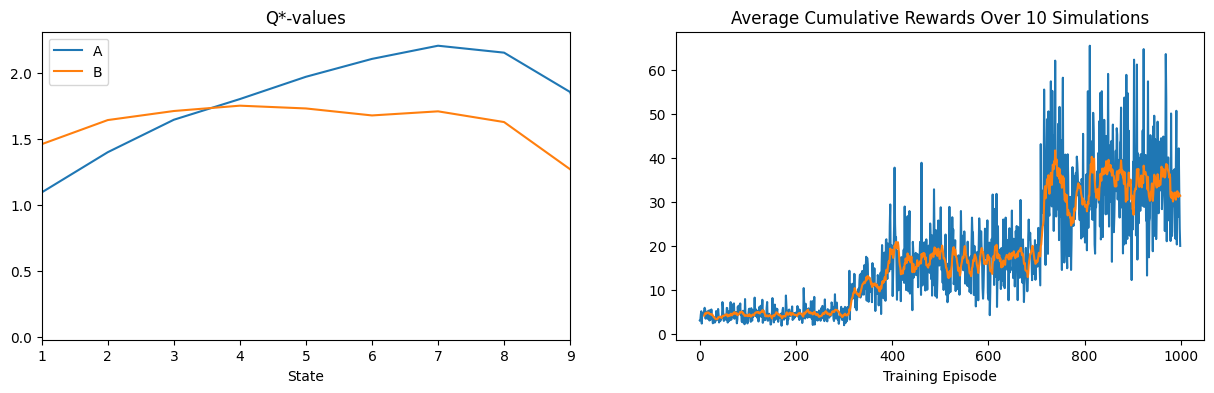

In [2]:
myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 1)
myFrog.q_learning(1000)
myFrog.all_plots()

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

training episode 397
training episode 398
training episode 399
training episode 400
training episode 401
training episode 402
training episode 403
training episode 404
training episode 405
training episode 406
training episode 407
training episode 408
training episode 409
training episode 410
training episode 411
training episode 412
training episode 413
training episode 414
training episode 415
training episode 416
training episode 417
training episode 418
training episode 419
training episode 420
training episode 421
training episode 422
training episode 423
training episode 424
training episode 425
training episode 426
training episode 427
training episode 428
training episode 429
training episode 430
training episode 431
training episode 432
training episode 433
training episode 434
training episode 435
training episode 436
training episode 437
training episode 438
training episode 439
training episode 440
training episode 441
training episode 442
training episode 443
training epis

training episode 799
training episode 800
training episode 801
training episode 802
training episode 803
training episode 804
training episode 805
training episode 806
training episode 807
training episode 808
training episode 809
training episode 810
training episode 811
training episode 812
training episode 813
training episode 814
training episode 815
training episode 816
training episode 817
training episode 818
training episode 819
training episode 820
training episode 821
training episode 822
training episode 823
training episode 824
training episode 825
training episode 826
training episode 827
training episode 828
training episode 829
training episode 830
training episode 831
training episode 832
training episode 833
training episode 834
training episode 835
training episode 836
training episode 837
training episode 838
training episode 839
training episode 840
training episode 841
training episode 842
training episode 843
training episode 844
training episode 845
training epis

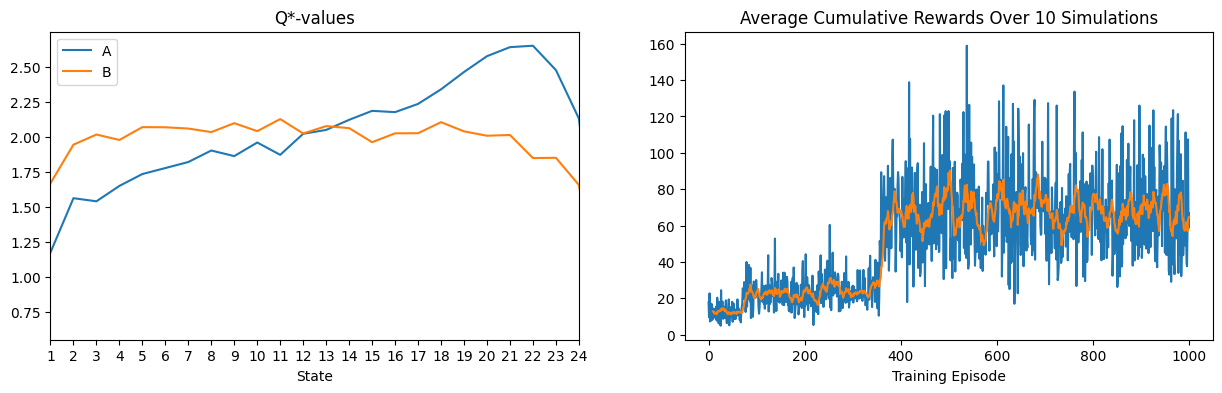

In [3]:
myFrog = Frog(n=25, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 1)
myFrog.q_learning(1000)
myFrog.all_plots()

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

training episode 403
training episode 404
training episode 405
training episode 406
training episode 407
training episode 408
training episode 409
training episode 410
training episode 411
training episode 412
training episode 413
training episode 414
training episode 415
training episode 416
training episode 417
training episode 418
training episode 419
training episode 420
training episode 421
training episode 422
training episode 423
training episode 424
training episode 425
training episode 426
training episode 427
training episode 428
training episode 429
training episode 430
training episode 431
training episode 432
training episode 433
training episode 434
training episode 435
training episode 436
training episode 437
training episode 438
training episode 439
training episode 440
training episode 441
training episode 442
training episode 443
training episode 444
training episode 445
training episode 446
training episode 447
training episode 448
training episode 449
training epis

training episode 795
training episode 796
training episode 797
training episode 798
training episode 799
training episode 800
training episode 801
training episode 802
training episode 803
training episode 804
training episode 805
training episode 806
training episode 807
training episode 808
training episode 809
training episode 810
training episode 811
training episode 812
training episode 813
training episode 814
training episode 815
training episode 816
training episode 817
training episode 818
training episode 819
training episode 820
training episode 821
training episode 822
training episode 823
training episode 824
training episode 825
training episode 826
training episode 827
training episode 828
training episode 829
training episode 830
training episode 831
training episode 832
training episode 833
training episode 834
training episode 835
training episode 836
training episode 837
training episode 838
training episode 839
training episode 840
training episode 841
training epis

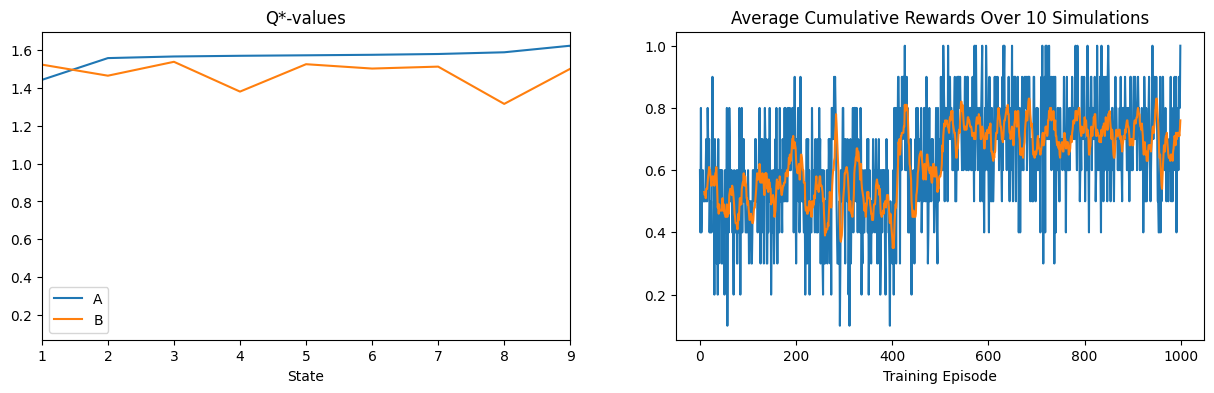

In [6]:
myFrog = Frog(n=10, gamma = 0.9999, initial_alpha = 0.2, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 1, rewards_choice = 2)
myFrog.q_learning(1000)
myFrog.all_plots()